# Laboratorium 5 - Wprowadzenie do uczenia głębokiego, klasyfikacja
## Techniki Obrazowania Medycznego - AGH 
**Kontakt: wodzinski@agh.edu.pl / MSTeams**


W trakcie laboratorium zostanie zaimplementowany przykład prostego problemu klasyfikacji z wykorzystaniem algorytmów uczenia głębokiego.

Laboratorium można podzielić na następujące części:
<ul>
<li> Wczytanie i wizualizaja zbioru treningowego i testowego </li>
<li> Implementacja prostej sieci konwolucyjnej </li>
<li> Trening sieci konwolucyjnej </li>
<li> Analiza uzyskanych wyników na zbiorze testowym </li>

## Część I - Wczytanie i wizualizacja zbioru danych

W pierwszej części zajęć należy dokonać wczytania zbioru danych i jego wizualnej inspekcji. Na zajęciach będziemy wykorzystywać otwarty zbiór danych z platformy Kaggle zawierający obrazy nowotworów mózgu pochodzące z rezonansu magnetycznego.
Dla uproszczenia problemu i uczynienia go bardziej dydaktycznym zostały wybrane jedynie pojedyczne przekroje dla każdego przypadku.
Zbiór danych oraz jego pełny opis: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

Zbiór danych został podzielony na zbiór treningowy oraz testowy. Najcześciej wyróżnia się jeszcze dodatkowy zbiór walidacyjny, natomiast - dla uproszczenia - taki podział zostanie dokonany dopiero na kolejnym laboratorium.
Przypadki zostały podzielone na cztery klasy: glejaki, oponiaki, gruczolaki, oraz przypadki bez nowotworu.

W przypadku algorytmów uczenia głębokiego, na potrzeby treningu, często definiuje się specjalne struktury danych służące do wczytania i wstępnego przetwarzania danych poza wątkiem głównym skryptu, czyli tzw. Datasety wykorzystywane dalej przez Dataloadery.
Rozpocznijmy od zdefiniowania własnej klasy do wczytywania danych (bardziej szczegółowe wprowadzenie: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install SimpleITK

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 2.0 MB/s 


In [ ]:
import os
import numpy as np
import torch as tc
import torchvision as tv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
from torchvision.transforms import ToTensor, Resize, Grayscale, RandomHorizontalFlip


path_to_dataset = r'/content/drive/My Drive/dat/Dataset1' # Path to the downloaded and unzipped dataset

class OurDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path) # Założenie, że klasy reprezentowane są przez nazwy folderów
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}") # Mapowanie nazwy klasy do liczby

        # Utworzenie listy wszystkich przypadków treningowych (w praktyce robi się to w plikach zewnętrznych)
        # Utwórz listę zawierającą krotki, gdzie każda krotka zawiera parę (scieżka do zdjęcia, 
        # numeryczna reprezentacja klasy zdjęcia)
        self.cases = []
        for current_class in self.classes:
            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                case_path = os.path.join(self.data_path, current_class, current_case)
                current_case = (case_path, self.classes_dict.get(current_class))#tu jakos ze slownika liczbe pobrac
                self.cases.append(current_case)
                # TODO - utworz odpowiednie krotki i dodaj je do listy self.cases

    def __len__(self): #(około 2 tys elementow)
        # Przeciążanie funkcji niezbędnej do określenia wielkości zbioru danych
        #raise NotImplementedError #TODO - wyznacz wielkosc aktualnie wczytywanego zbioru
        return len(self.cases)

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path = current_case[0]
        current_class = current_case[1]
        current_image = sitk.GetArrayFromImage(sitk.ReadImage(current_path)).astype("float32")

        current_image = (current_image - np.min(current_image)) / (np.max(current_image) - np.min(current_image)) #TODO - normalizacja do zakresu [0-1]

        current_image = ToTensor()(current_image) #konwersja na tensor

        # Poszczególne zdjęcia mogą mieć inną rozdzielczość - dla uproszczenia dokonajmy resamplingu do tej 
        # samej rozdzielczości (224x224), następnie konwersji do skali szarości i normalizacji

        current_image = RandomHorizontalFlip(p=1)(current_image) #TODO - konwersja do NumPy i zmiana kolejnosci wymiarow
        current_image = Grayscale(1)(current_image)#TODO - konwersja do skali szarosci i typu float32
        current_image = Resize((224,224))(current_image)#TODO - resampling do 224x224 #resample z torch vison albo funkcja map cordinates

        return current_image, current_class



training_dataset = OurDataset(path_to_dataset, "training") # Utworzenie zbioru treningowego
testing_dataset = OurDataset(path_to_dataset, "testing") # Utworzenie zbioru testowego
batch_size = 16 # Okreslenie ile przypadkow ma byc naraz wczytywane i procesowane -> istotny hyperparameter w trakcie treningu
shuffle = True # Czy przypadki w każdej epocje mają być wczytywane losowo. Epoka - każdorazowe przeiterowanie przez cały zbiór treningowy
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False)



Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Następnie sprawdź działanie zaimplementowanej funkcji iterując po zaimplementowanym dataloaderze, pokazując wczytywane przypadki.

torch.float32


ValueError: ignored

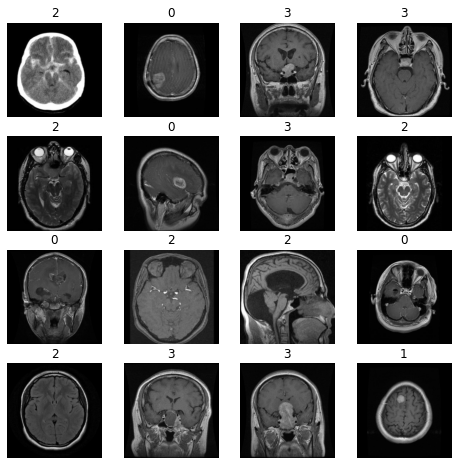

In [ ]:
train_features, train_labels = next(iter(training_dataloader))

plt.figure(figsize=(8,8))

for i in range(batch_size):
  plt.subplot(4, 4, i+1)
  img = train_features[i].squeeze()
  plt.imshow(img, cmap="gray")
  plt.title(f"{train_labels[i]}")
  plt.axis('off')

plt.tight_layout()

## Część II - Implementacja prostej sieci konwolucyjnej

Kolejnym krokiem jest zdefiniowanie prostej sieci konwolucyjnej.
W tym przypadku zaproponujmy bardzo prostą architekturę składającą się z następujących wywołanych przez siebie sekwencyjnie elementów:
(przykład definiowania i treningu własnej sieci neuronowej: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

<ol>
<li> Warstwa konwolucyjna (2-D) z IS: 1, OS: 32, Kernel Size: 3,  Stride: 1, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 32, OS: 32, z Kernel Size: 3,  Stride: 2, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 32, OS: 64, z Kernel Size: 3,  Stride: 1, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 64, OS: 64, z Kernel Size: 3,  Stride: 2, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 64, OS: 128, z Kernel Size: 3,  Stride: 1, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 128, OS: 128, z Kernel Size: 3,  Stride: 2, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa konwolucyjna (2-D) z IS: 128, OS: 128, z Kernel Size: 3,  Stride: 1, Padding: 1</li>
<li> Warstwa normalizująca Batch Normalization</li>
<li> Funkcja aktywacji ReLU</li>
<li> Warstwa uśredniająca AvgPool</li>
</ol>

Powyższa sieć neuronowa jest bardzo prosta i mocno nieidealna. Implementacją bardziej efektywnych architektur będziemy się zajmować na kolejnych laboratoriach.

In [ ]:
import torch.nn as nn

class SimpleNetwork(tc.nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.layer_1 = tc.nn.Sequential(
            tc.nn.Conv2d(1, 32, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU()
        ) # Przyklad pierwszej warstwy (1-3)
        self.layer_2 = tc.nn.Sequential(
            tc.nn.Conv2d(32, 32, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU()
        ) 
        self.layer_3 =tc.nn.Sequential(
            tc.nn.Conv2d(32, 64, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        ) 
        self.layer_4 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 64, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU()
        ) 
        self.layer_5 = tc.nn.Sequential(
            tc.nn.Conv2d(64, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        ) 
        self.layer_6 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=2, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        ) 
        self.layer_7 = tc.nn.Sequential(
            tc.nn.Conv2d(128, 128, 3, stride=1, padding=1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU()
        ) 

        self.avg_pool = tc.nn.Sequential(
            tc.nn.AvgPool2d(1, 1) 
        )

        self.last_layer = tc.nn.Sequential(
            tc.nn.Linear(128*28*28, 4)
        )

    def forward(self, x):
        x = self.layer_1(x) # Przyklad uzycia pierwszej warstwy
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.avg_pool(x)
        x = x.view(-1, 128*28*28) 
        x = self.last_layer(x) 
        return x

W kolejnym kroku spróbujmy przez sieć przepuścić przykładowe obrazy i zaobserwujmy wyniki.

In [ ]:
model = SimpleNetwork()
for images, classes in training_dataloader:
    output = model(images) # <- Kluczowa linijka kodu, wywołanie funkcji **forward** z klasy SimpleNetwork
    print(f"Output: {tc.nn.Sigmoid()(output)}") # <- w praktyce Sigmoid w celu wyznaczania prawdopodobieństwa umieszcza się poza siecią neuronową
    break

Output: tensor([[0.5445, 0.4698, 0.4324, 0.5868],
        [0.3466, 0.5204, 0.3637, 0.7246],
        [0.4300, 0.4253, 0.4118, 0.6845],
        [0.4610, 0.3904, 0.4272, 0.6747],
        [0.5031, 0.5329, 0.2014, 0.7297],
        [0.5674, 0.4170, 0.3260, 0.5658],
        [0.4820, 0.4815, 0.4760, 0.6303],
        [0.5808, 0.5942, 0.3418, 0.5700],
        [0.3529, 0.5303, 0.3603, 0.7242],
        [0.4023, 0.4166, 0.3448, 0.6353],
        [0.6074, 0.4501, 0.3041, 0.5956],
        [0.4998, 0.4309, 0.3849, 0.6452],
        [0.5078, 0.4285, 0.3111, 0.6433],
        [0.4574, 0.4205, 0.4454, 0.6460],
        [0.4363, 0.5321, 0.3759, 0.4652],
        [0.5531, 0.3647, 0.5128, 0.6197]], grad_fn=<SigmoidBackward0>)


Wyniki są zgodne z oczekiwaniami - sieć zwraca de facto losowe wartości i nie potrafi podjąć żadnej decyzji. Nie została jeszcze nauczona by wykrywać i rozpoznawać poszczególne wzorce.

## Część III - Trening sieci konwolucyjnej

W kolejnym kroku dokonamy treningu zaimplementowanej sieci neuronowej. Będziemy ją trenować w sposób nadzorowany, tj. niejako pokazując sieci zadany przypadek i przyporządkowaną do niego klase. Tzw. supervised learning jest najpopularniejszym i najłatwiejszym sposobem trenowania sieci neuronowych jednak obarczony jest fundamentalną wadą - wymaga anotacji zbioru treningowego co w przypadku danych medycznych jest niezwykle kosztowne.

Na początku zdefiniujmy optymalizator i parametry treningu:

In [ ]:
learning_rate = 0.003 # Współczynnik uczenia, definiuje szybkość treningu, zbyt duży prowadzi do niestabilności, zbyt niski do wolnego uczenia
batch_size = 32 # Liczba obrazów analizowanych w zadanym momencie - większa wartość prowadzi do lepszego wykorzystania GPU, jednak może powodować większy potencjał do wpadania w minima lokalne
num_epochs = 100 # Liczba iteracji przez cały zbiór treningowy
objective_function = tc.nn.CrossEntropyLoss() # Funkcja kosztu, która będzie minimalizowana
model = SimpleNetwork()
parameters = model.parameters() # Parametry, które będą optymalizowane w trakcie treningu sieci
optimizer = tc.optim.Adam(parameters, lr=learning_rate) # Utworzenie obiektu optymalizatora -> w tym przypadku Adam (najpopularniejszy), w uproszczeniu - bardziej zaawansowany wariant spadku gradientowego
device = tc.device("cuda:0") # Urządzenie, na którym będzie prowadzony trening, użyjmy karty graficznej, ew. zmienić na "cpu" w przypadku jej braku. Karty graficzne są dostępnę na Google Colaboratory

training_dataset = OurDataset(path_to_dataset, "training")
shuffle = True 
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Następnie zaimplementujmy pętlę treningową:

In [ ]:
losses = []
model = model.to(device) # Transfer sieci do pamięci urządzenia (np. GPU)
model.train()

print(f"Dataset size: {len(training_dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    epoch_loss = 0.0

    for images, classes in training_dataloader:

        images, classes = images.to(device), classes.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        
        output = model(images) # Przejście obrazów przez model

        loss = objective_function(output, classes) # TODO - wyznacz aktualna funkcje kosztu
        
        loss.backward() # TODO - dokonaj backpropagacji gradientu wykorzystując wyznaczona wartosc kosztu
        
        optimizer.step() # TODO - dokonaj aktualizacji optymalizatora
        
        optimizer.zero_grad() # TODO - wyzeruj historie gradientu w optymalizatorze

        epoch_loss += loss.item() * images.size(0)

    epoch_loss = epoch_loss / len(training_dataloader.dataset)
    losses.append(epoch_loss)
    print(f"Current epoch loss: {epoch_loss}")

# Wizualizacja pętli treningowej
plt.figure()
plt.plot(losses, "r-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Dataset size: 2870
Current epoch: 0
Current epoch loss: 3.6121540612875376
Current epoch: 1
Current epoch loss: 1.5537573615848395
Current epoch: 2
Current epoch loss: 0.7895579500896175
Current epoch: 3
Current epoch loss: 0.8256636601291882
Current epoch: 4
Current epoch loss: 0.4393517108744445
Current epoch: 5
Current epoch loss: 0.34603673909183996
Current epoch: 6
Current epoch loss: 0.2992486282715814
Current epoch: 7
Current epoch loss: 0.19910884458532732
Current epoch: 8
Current epoch loss: 0.22812741443462903
Current epoch: 9
Current epoch loss: 0.2583417165881665
Current epoch: 10
Current epoch loss: 0.19366318568950747
Current epoch: 11
Current epoch loss: 0.13421034105771096
Current epoch: 12
Current epoch loss: 0.13974548574108694
Current epoch: 13
Current epoch loss: 0.10428803668516438
Current epoch: 14
Current epoch loss: 0.0866761723072479
Current epoch: 15
Current epoch loss: 0.10609470504605396
Current epoch: 16
Current epoch loss: 0.07233244339296212
Current epoch

KeyboardInterrupt: ignored

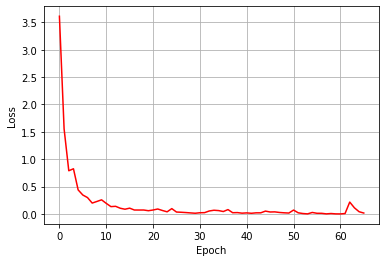

In [ ]:
# Wizualizacja pętli treningowej
plt.figure()
plt.plot(losses, "r-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Część IV - Analiza wyników osobno na zbiorze treningowym i zbiorze testowym

Dokonaliśmy treningu sieci. W kolejnym kroku dokonajmy analizy wyników klasyfikacji odpowiednio na zbiorze treningowym oraz zbiorze testowym. Dokonajmy tego wykorzystując znaną z ADP metodę opartą na macierzy pomyłek (biblioteka sklearn), oraz wizualizując wyniki dla wybranych przypadków.

Dokonaj analizy ilościowej na zbiorze treningowym:

Dataset size: 2870
Training confusion matrix: 
 [[826   0   0   0]
 [  0 821   1   0]
 [  0   1 394   0]
 [  0   0   0 827]]


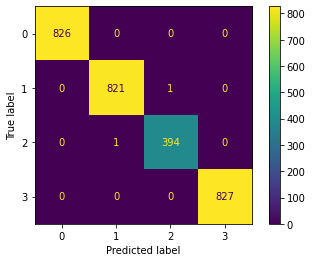

Training classification report: 
               precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       826
  Meningioma       1.00      1.00      1.00       822
    No_Tumor       1.00      1.00      1.00       395
   Pituitary       1.00      1.00      1.00       827

    accuracy                           1.00      2870
   macro avg       1.00      1.00      1.00      2870
weighted avg       1.00      1.00      1.00      2870



In [ ]:
import sklearn.metrics as metrics

predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(training_dataloader.dataset)}")
    for images, classes in training_dataloader:

        images, classes = images.to(device), classes.to(device)
        output = model(images)
        
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

        predictions.extend(prediction.cpu().numpy().tolist()) 

        targets.extend(classes.cpu().numpy().tolist())


cm = metrics.confusion_matrix(targets, predictions)
print("Training confusion matrix: \n",cm) 

metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Training classification report: \n", metrics.classification_report(
    targets, predictions, target_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]))

Które klasy są między sobą najczęściej mylone? Jak myślisz - dlaczego?

Dokonaj analizy ilościowej na zbiorze testowym:

Dataset size: 394
Testing confusion matrix: 
 [[ 18  34  46   2]
 [  0 115   0   0]
 [  0   0 105   0]
 [  0  16  10  48]]


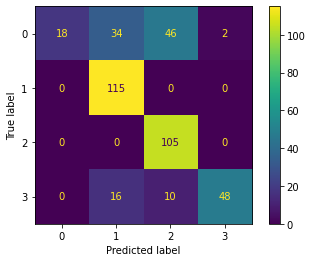

Testing classification report: 
               precision    recall  f1-score   support

      Glioma       1.00      0.18      0.31       100
  Meningioma       0.70      1.00      0.82       115
    No_Tumor       0.65      1.00      0.79       105
   Pituitary       0.96      0.65      0.77        74

    accuracy                           0.73       394
   macro avg       0.83      0.71      0.67       394
weighted avg       0.81      0.73      0.67       394



In [ ]:
predictions = []
targets = []
model.eval()

with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(testing_dataloader.dataset)}")
    for images, classes in testing_dataloader:

        images, classes = images.to(device), classes.to(device)
        output = model(images)

        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

        predictions.extend(prediction.cpu().numpy().tolist()) 

        targets.extend(classes.cpu().numpy().tolist())


cm = metrics.confusion_matrix(targets, predictions)
print("Testing confusion matrix: \n", cm) 

metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Testing classification report: \n", metrics.classification_report(
    targets, predictions, target_names = ["Glioma", "Meningioma", "No_Tumor", "Pituitary"]))


Dokonaj analizy wizualnej na zbiorze testowym. Pokaż tylko te przypadki, które zostały błędnie zaklasyfikowane podając obok zdjęcia wyznaczoną oraz rzeczywistą klasę.

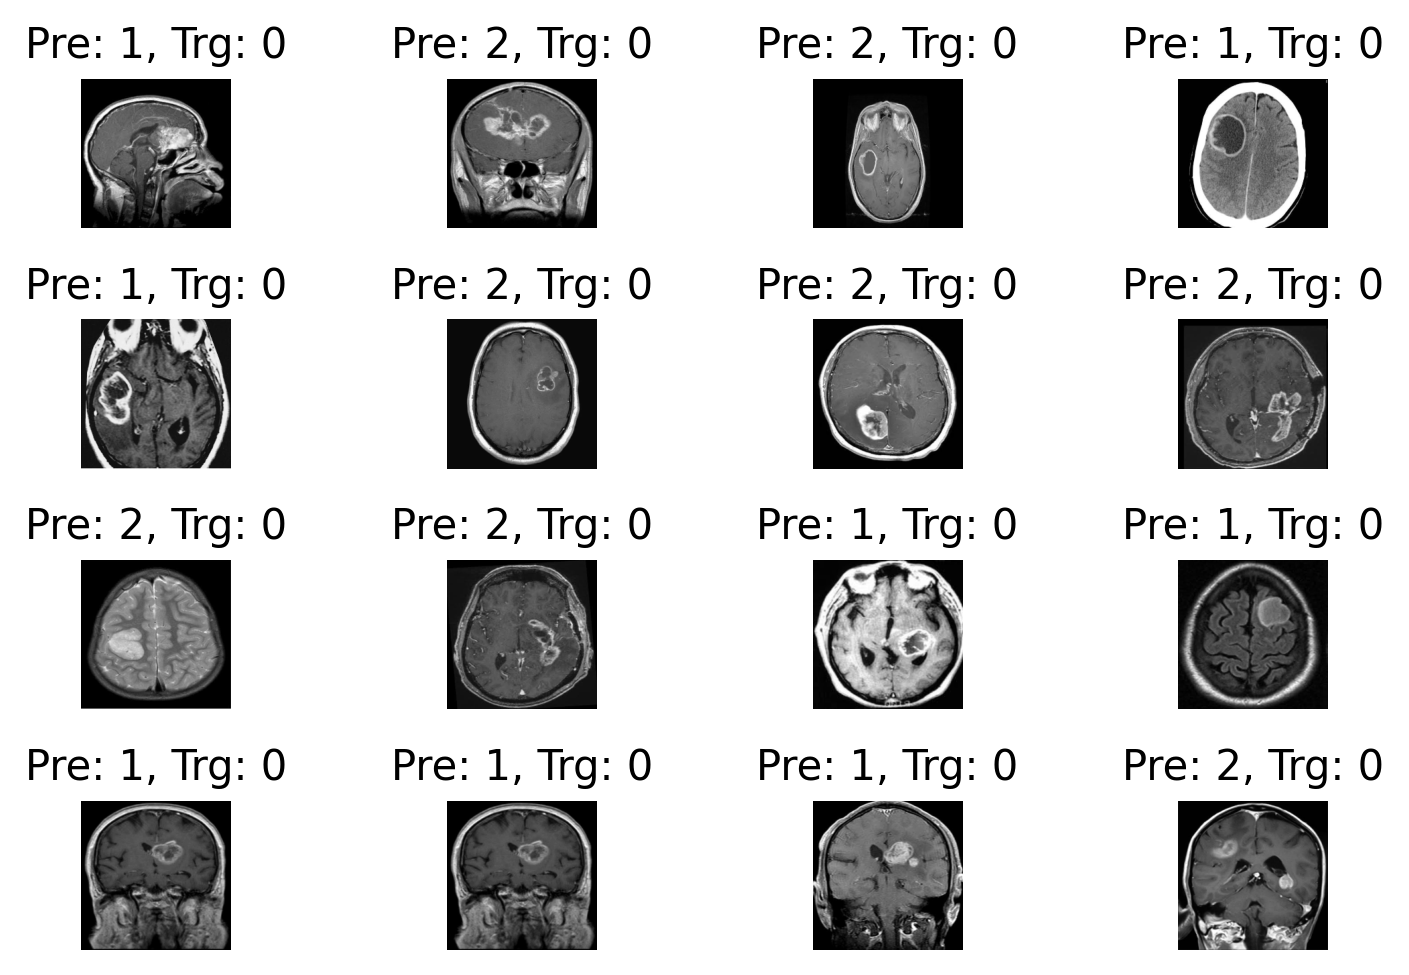

In [ ]:
incorrect_tuples = []
predictions = []
targets = []
image = []

max_size = 16
i=0

for images, classes in testing_dataloader:
    images, classes = images.to(device), classes.to(device)
    output = model(images) # Przejście obrazów przez model

    prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)

    if prediction != classes:

        predictions.extend(prediction.cpu().numpy().tolist()) 

        targets.extend(classes.cpu().numpy().tolist())

        image.extend(images.cpu().numpy())

        i=i+1

    if i == max_size:
      break


incorrect_tuples.insert(0, image)
incorrect_tuples.insert(1, predictions)
incorrect_tuples.insert(2, targets)

# TODO - dokonaj akumulacji pierwszych 16 przypadków gdzie wyznaczona klasa rozni sie od rzeczyistej i dodaj je do listy incorrect_tupples w fomracie (zdjecie w formacie numpy, predykcja, ground-truth)

rows = 4
cols = 4

plt.figure(dpi=250)
for i in range(len(incorrect_tuples[0])):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(incorrect_tuples[0][i].squeeze(), cmap='gray')
    to_print = f"Pre: {incorrect_tuples[1][i]}, Trg: {incorrect_tuples[2][i]}"
    plt.title(to_print)
    plt.axis('off')
plt.tight_layout()
plt.show()


Z czego mogą wynikać różnice między zbiorem treningowym, a zbiorem testowym? Jak można je minimalizować? Czy potrafisz wyjaśnić dlaczego sieć neuronowa podjęła taką, a nie inną decyzje?

Na kolejnym laboratorium zostanie omówiony temat segmentacji obrazów medycznych wykorzystując uczenie głębokie, w czasie którego poruszony zostanie również dodatkowy podział na zbiór walidacyjny, temat under- oraz over-fittingu, oraz zagadnienie augmentacji.